# Using the Sup3rCC Data

This notebook has examples of how to access and use the Sup3rCC data. Note that you don't need a full sup3r software installation to run this notebook. Just a simple [rex](https://github.com/NREL/rex) environment with matplotlib will do it. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from rex import MultiFileResourceX, ResourceX

## Importing the Data

Here we load data from the 2015 and the 2050 files. Note that:

1. The 2015 year does not represent the actual historical weather in 2015, just the historical climate in 2015
2. Comparing single years is inprecise because interannual variability can skew the results, we use single years here just for illustrative purposes
3. The access patterns are different if you're on Eagle (the NREL supercomputer) versus if you're accessing via a remote machine. In the latter case, you'll need to use HSDS. See the instructions [here](https://nrel.github.io/rex/misc/examples.hsds.html) for more details on how to set that up. The code below assumes you'll use an NREL API key, but if you want to setup a local HSDS server you'll have to modify `hsds_kwargs` accordingly. The NREL API can throw ambiguous errors such as `OSError: Error retrieving data: None`. This typically happens if the NREL API is down, is experiencing bandwidth issues, or if you're attempting to read too much data for the public service (see the rex hsds examples link above for instructions on how to set up your own HSDS service)

In [2]:
option = 'hsds'

if option == 'eagle':
    # Use this code block if you want to access Sup3rCC data on Eagle
    data_dir = '/datasets/sup3rcc/conus_mriesm20_ssp585_r1i1p1f1/'
    fn_2015 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_*_2015.h5'
    fn_2050 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_*_2050.h5'
    handler_2015 = MultiFileResourceX(os.path.join(data_dir, fn_2015))
    handler_2050 = MultiFileResourceX(os.path.join(data_dir, fn_2050))
    
elif option == 'hsds':
    # Use this code block if you want to access Sup3rCC data remotely via HSDS
    data_dir = '/nrel/sup3rcc/conus_mriesm20_ssp585_r1i1p1f1/'
    fn_2015 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_2015.h5'
    fn_2050 = 'sup3rcc_conus_mriesm20_ssp585_r1i1p1f1_2050.h5'
    hsds_kwargs = {'endpoint': 'https://developer.nrel.gov/api/hsds', 
                   'api_key': '{YOUR_API_KEY_HERE}',
                  }
    handler_2015 = ResourceX(os.path.join(data_dir, fn_2015), hsds=True, hsds_kwargs=hsds_kwargs)
    handler_2050 = ResourceX(os.path.join(data_dir, fn_2050), hsds=True, hsds_kwargs=hsds_kwargs)

else:
    raise NotImplementedError

In [3]:
# coordinate for NREL campus
coord = (39.741, -105.171)

dsets = handler_2015.dsets
gid = handler_2015.lat_lon_gid(coord)
meta = handler_2015.meta
ti_2015 = handler_2015.time_index
data_2015 = pd.DataFrame({'ghi': handler_2015['ghi', :, gid],
                          'ws': handler_2015['windspeed_100m', :, gid],
                          'temp': handler_2015['temperature_2m', :, gid]},
                         index=ti_2015)

ti_2050 = handler_2050.time_index
data_2050 = pd.DataFrame({'ghi': handler_2050['ghi', :, gid],
                          'ws': handler_2050['windspeed_100m', :, gid],
                          'temp': handler_2050['temperature_2m', :, gid]},
                         index=ti_2050)

display(dsets)
display(meta.loc[gid])

['dhi',
 'dni',
 'ghi',
 'meta',
 'pressure_0m',
 'relativehumidity_2m',
 'temperature_2m',
 'time_index',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_200m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_200m']

latitude         39.723133
longitude      -105.165001
timezone              -7.0
elevation             1876
country      United States
state             Colorado
county           Jefferson
offshore                 0
eez                      1
Name: 389950, dtype: object

## Comparing Differences in Temperature

Here, we can see that 2050 has an increase in average dry bulb temperature versus 2015, as well as more extreme hot and cold events.

,ghi,ws,temp
count,8760.000000,8760.000000,8760.000000
mean,209.282648,3.378573,8.700505
std,286.185285,2.151688,10.412423
min,0.000000,0.010000,-19.379999
25%,0.000000,1.860000,0.380000
50%,0.000000,2.920000,7.610000
75%,402.000000,4.390000,16.850000
max,1023.000000,16.480000,34.540001


,ghi,ws,temp
count,8760.000000,8760.000000,8760.000000
mean,221.332192,3.564847,9.954342
std,296.234492,2.364555,12.076827
min,0.000000,0.010000,-25.790001
25%,0.000000,1.860000,0.620000
50%,0.000000,3.020000,9.210000
75%,439.000000,4.680000,19.450001
max,1036.000000,15.250000,38.080002


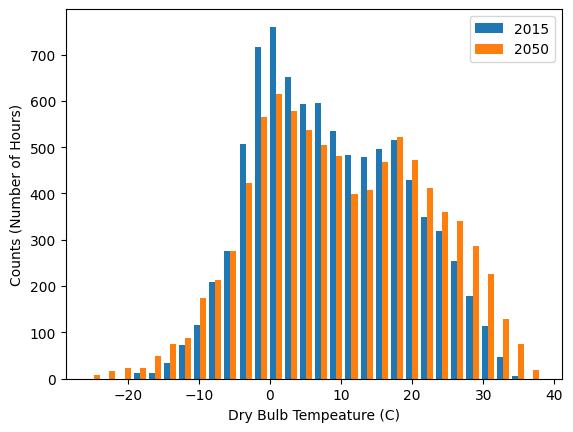

In [4]:
display(data_2015.describe())
display(data_2050.describe())

plt.hist([data_2015['temp'].values, data_2050['temp'].values], bins=30);
plt.xlabel('Dry Bulb Tempeature (C)')
plt.ylabel('Counts (Number of Hours)')
plt.legend(['2015', '2050'])

# Wind and Solar Resource

You can use joint probability distributions to visualize the distribution of syncronous wind and solar resources. In practice, you would want to use a tool like the System Advisor Model (SAM) or the Renewable Energy Potential Model (reV) to convert these meteorological variables into potential power generation.

Text(0, 0.5, '2050 Hourly Windspeed (m/s)')

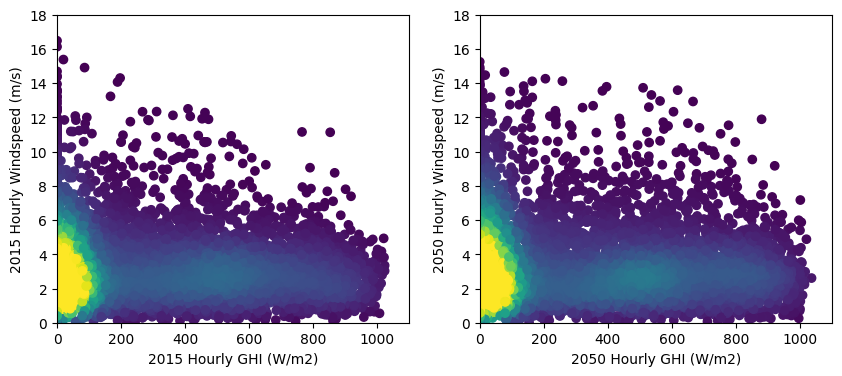

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_density(x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / (z.max() - z.min())
    return z

c1 = get_density(data_2015['ghi'], data_2015['ws'])
c2 = get_density(data_2050['ghi'], data_2050['ws'])

ax[0].scatter(data_2015['ghi'], data_2015['ws'], c=c1, vmin=0, vmax=0.5)
ax[1].scatter(data_2050['ghi'], data_2050['ws'], c=c2, vmin=0, vmax=0.5)

for subax in ax:
    subax.set_xlim(0, 1100)
    subax.set_ylim(0, 18)
    
ax[0].set_xlabel('2015 Hourly GHI (W/m2)')
ax[0].set_ylabel('2015 Hourly Windspeed (m/s)')
ax[1].set_xlabel('2050 Hourly GHI (W/m2)')
ax[1].set_ylabel('2050 Hourly Windspeed (m/s)')

Text(0, 0.5, '2050 Daily Average Windspeed (m/s)')

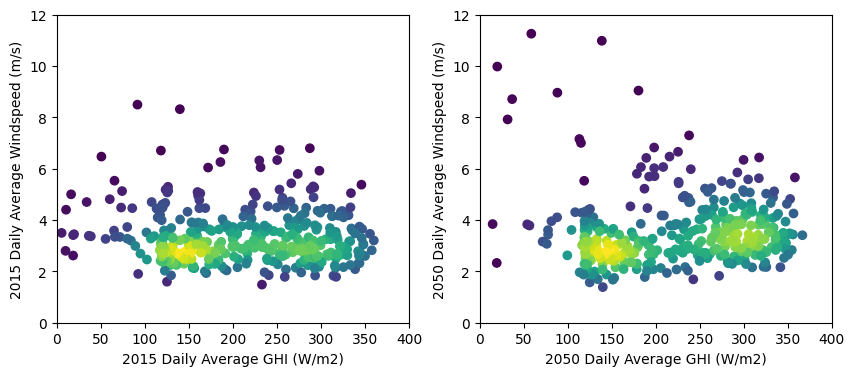

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

def get_daily_means(arr):
    arr = np.roll(arr, -7)
    day_slices = [slice(i, i+24) for i in range(0, 8760, 24)]
    arr = [arr[islice].mean() for islice in day_slices]
    return np.array(arr)

ghi_2015 = get_daily_means(data_2015['ghi'])
ghi_2050 = get_daily_means(data_2050['ghi'])
ws_2015 = get_daily_means(data_2015['ws'])
ws_2050 = get_daily_means(data_2050['ws'])

c1 = get_density(ghi_2015, ws_2015)
c2 = get_density(ghi_2050, ws_2050)

ax[0].scatter(ghi_2015, ws_2015, c=c1, vmin=0, vmax=1)
ax[1].scatter(ghi_2050, ws_2050, c=c2, vmin=0, vmax=1)

for subax in ax:
    subax.set_xlim(0, 400)
    subax.set_ylim(0, 12)
    
ax[0].set_xlabel('2015 Daily Average GHI (W/m2)')
ax[0].set_ylabel('2015 Daily Average Windspeed (m/s)')
ax[1].set_xlabel('2050 Daily Average GHI (W/m2)')
ax[1].set_ylabel('2050 Daily Average Windspeed (m/s)')

Text(0, 0.5, '2050 Daily Average Windspeed (m/s)')

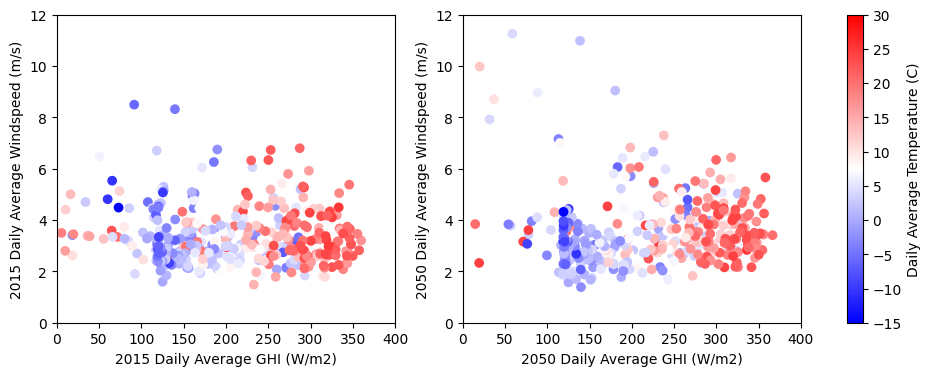

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

def get_daily_means(arr):
    arr = np.roll(arr, -7)
    day_slices = [slice(i, i+24) for i in range(0, 8760, 24)]
    arr = [arr[islice].mean() for islice in day_slices]
    return np.array(arr)

ghi_2015 = get_daily_means(data_2015['ghi'])
ghi_2050 = get_daily_means(data_2050['ghi'])
ws_2015 = get_daily_means(data_2015['ws'])
ws_2050 = get_daily_means(data_2050['ws'])
temp_2015 = get_daily_means(data_2015['temp'])
temp_2050 = get_daily_means(data_2050['temp'])

a = ax[0].scatter(ghi_2015, ws_2015, c=temp_2015, vmin=-15, vmax=30, cmap='bwr')
b = ax[1].scatter(ghi_2050, ws_2050, c=temp_2015, vmin=-15, vmax=30, cmap='bwr')
plt.colorbar(b, ax=ax, label='Daily Average Temperature (C)')

for subax in ax:
    subax.set_xlim(0, 400)
    subax.set_ylim(0, 12)
    
ax[0].set_xlabel('2015 Daily Average GHI (W/m2)')
ax[0].set_ylabel('2015 Daily Average Windspeed (m/s)')
ax[1].set_xlabel('2050 Daily Average GHI (W/m2)')
ax[1].set_ylabel('2050 Daily Average Windspeed (m/s)')